# import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
df = pd.read_csv("data_tmp/bakery_sales.csv")
df_bakery = pd.read_csv("data_tmp/bakery_sales_reduit.csv")

In [11]:
df.shape

(234005, 7)

In [12]:
df

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


# For hichem

Make sure everithing is robust:
- robust to accidental whitespace/case
- with what we fill the Nan??

In [27]:
# Ensure column names are as expected (robust to accidental whitespace/case)
df.columns = [c.strip().lower() for c in df.columns]

# Coerce types we need
df['article'] = df['article'].astype(str).str.strip()
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce').fillna(0)

In [64]:
if 'unit_price' in df.columns:
     df['unit_price'] = (
         df['unit_price'].astype(str)
         .str.replace('€', '', regex=False)
         .str.replace('.', '', regex=False)    # remove thousands dots if any
         .str.replace(',', '.', regex=False)   # decimal comma -> dot
         .str.strip()
     )
     df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')

# Articles density

What article of the bakery is more popular

In [29]:
# 1) Total quantity sold per article (best measure of "more bought")
qty_by_article = (
    df.groupby('article', as_index=False)['quantity']
      .sum()
      .sort_values('quantity', ascending=False)
      .rename(columns={'quantity': 'total_quantity'})
)

# 2) How often each article appears (number of rows) for "appears frequently", regardless of amount
linecount_by_article = (
    df['article'].value_counts().rename_axis('article').reset_index(name='line_count')
)

In [ ]:
# Articles only bought once
qty_by_article[qty_by_article["total_quantity"]<2]

,article,total_quantity
119,SACHET DE VIENNOISERIE,1.0
105,"PLATPREPARE6,00",1.0
22,CAKE,1.0
143,TROIS CHOCOLAT,1.0
91,PAIN NOIR,1.0
3,ARTICLE 295,1.0
112,REDUCTION SUCREES 24,1.0
45,DOUCEUR D HIVER,1.0
100,PLAT 6.50E,0.0


In [38]:
# Articles only bought by one client
linecount_by_article[linecount_by_article["line_count"]<2]


,article,line_count
137,PLAQUE TARTE 25P,1
138,TARTELETTE COCKTAIL,1
139,ARTICLE 295,1
140,CAKE,1
141,TROIS CHOCOLAT,1
142,"PLATPREPARE6,00",1
143,REDUCTION SUCREES 24,1
144,PAIN NOIR,1
145,BUCHE 8PERS,1
146,CRUMBLECARAMEL OU PISTAE,1


In [57]:
linecount_by_article[:15]["article"].tolist()

['TRADITIONAL BAGUETTE',
 'COUPE',
 'BAGUETTE',
 'BANETTE',
 'CROISSANT',
 'PAIN AU CHOCOLAT',
 'SPECIAL BREAD',
 'CEREAL BAGUETTE',
 'FORMULE SANDWICH',
 'BOULE 400G',
 'CAMPAGNE',
 'VIK BREAD',
 'COMPLET',
 'MOISSON',
 'TARTELETTE']

In [62]:
for i in linecount_by_article[:15]["article"].tolist():
    if i not in qty_by_article[:15]["article"].tolist():
        total_qty = qty_by_article.loc[qty_by_article['article'] == i, 'total_quantity'].values[0]
        line_cnt = linecount_by_article.loc[linecount_by_article['article'] == i, 'line_count'].values[0]
        print(f"{i} is bought more frequently but in smaller quantity, {total_qty} times and in {line_cnt} occasions")
for j in qty_by_article[:15]["article"].tolist():
    if j not in linecount_by_article[:15]["article"].tolist():
        total_qty = qty_by_article.loc[qty_by_article['article'] == j, 'total_quantity'].values[0]
        line_cnt = linecount_by_article.loc[linecount_by_article['article'] == j, 'line_count'].values[0]
        print(f"{j} is bought less frequently but in bigger quantity {total_qty} times and in {line_cnt} occasions")

COMPLET is bought more frequently but in smaller quantity, 3535.0 times and in 3140 occasions
MOISSON is bought more frequently but in smaller quantity, 3362.0 times and in 3107 occasions
COOKIE is bought less frequently but in bigger quantity 3779.0 times and in 2002 occasions
ECLAIR is bought less frequently but in bigger quantity 3654.0 times and in 2006 occasions


In [39]:
# more bought and bought frequently in one dataframe
popularity = qty_by_article.merge(linecount_by_article, on='article', how='left')

In [73]:
print("\nTop 10 more bought:")
print(popularity.head(15).to_string(index=True))


Top 10 more bought:
                 article  total_quantity  line_count
0   TRADITIONAL BAGUETTE        117463.0       67689
1              CROISSANT         29654.0       11508
2       PAIN AU CHOCOLAT         25236.0       10578
3                  COUPE         23505.0       20470
4                BANETTE         22732.0       15130
5               BAGUETTE         22053.0       15292
6        CEREAL BAGUETTE          7427.0        4961
7          SPECIAL BREAD          5456.0        5195
8       FORMULE SANDWICH          5181.0        4202
9             TARTELETTE          5020.0        2861
10            BOULE 400G          4824.0        4099
11              CAMPAGNE          4356.0        3905
12                COOKIE          3779.0        2002
13                ECLAIR          3654.0        2006
14             VIK BREAD          3619.0        3147


In [43]:
TOP_N  = 20

In [52]:
def plot_all_articles_quantity(qty_df, SAVE_PLOTS=False, title="All articles — share of total quantity sold (%)"):
    """ Horizontal bar chart showing each article's share of total quantity (percentage)
    qty_df: DataFrame with 'article' and 'total_quantity' columns
    """
    df = qty_df.copy()
    df = df.sort_values('total_quantity', ascending=False)
    total = df['total_quantity'].sum()
    if total == 0:
        df['pct'] = 0.0
    else:
        df['pct'] = (df['total_quantity'] / total) * 100.0

    fig, ax = plt.subplots(figsize=(10, max(6, len(df) * 0.22)))
    ax.barh(df['article'], df['pct'])
    ax.invert_yaxis()  # largest at the top
    ax.set_xlabel("% of total quantity sold")
    ax.set_ylabel("Article")
    ax.set_title(title)
    plt.tight_layout()
    if SAVE_PLOTS:
        out = Path("all_articles_quantity_percent.png")
        plt.savefig(out, dpi=150)
        print(f"Saved: {out}")
    plt.show()


def plot_top_n_articles_quantity(qty_df, SAVE_PLOTS=False, n=TOP_N, title_prefix="Top"):
    """ Horizontal bar chart with top N entries by total quantity
    qty_df: DataFrame with 'article' and 'total_quantity' columns
    """
    top = qty_df.head(n)
    fig, ax = plt.subplots(figsize=(10, max(6, n * 0.35)))
    ax.barh(top['article'], top['total_quantity'])
    ax.invert_yaxis()
    ax.set_xlabel("Total quantity sold")
    ax.set_ylabel("Article")
    ax.set_title(f"{title_prefix} {n} articles — total quantity sold")
    plt.tight_layout()
    if SAVE_PLOTS:
        out = Path(f"top_{n}_articles_quantity.png")
        plt.savefig(out, dpi=150)
        print(f"Saved: {out}")
    plt.show()

def plot_top_n_by_linecount(pop_df, SAVE_PLOTS=False, n=TOP_N):
    """ Horizontal bar chart with top N entries by line count (frequency of appearance
    pop_df: DataFrame with 'article' and 'line_count' columns)
    """
    top = pop_df.sort_values('line_count', ascending=False).head(n)
    fig, ax = plt.subplots(figsize=(10, max(6, n * 0.35)))
    ax.barh(top['article'], top['line_count'])
    ax.invert_yaxis()
    ax.set_xlabel("Number of lines (appearances)")
    ax.set_ylabel("Article")
    ax.set_title(f"Top {n} articles — by frequency of appearance (line count)")
    plt.tight_layout()
    if SAVE_PLOTS:
        out = Path(f"top_{n}_articles_linecount.png")
        plt.savefig(out, dpi=150)
        print(f"Saved: {out}")
    plt.show()


In [ ]:
plot_all_articles_quantity(qty_by_article)


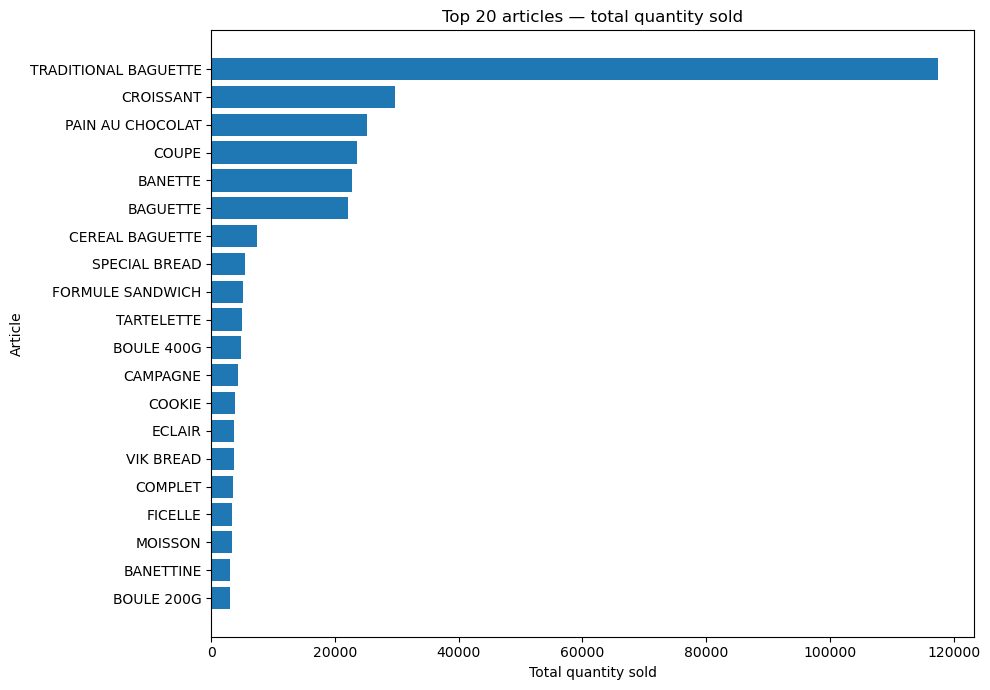

In [53]:
plot_top_n_articles_quantity(qty_by_article, n=TOP_N)


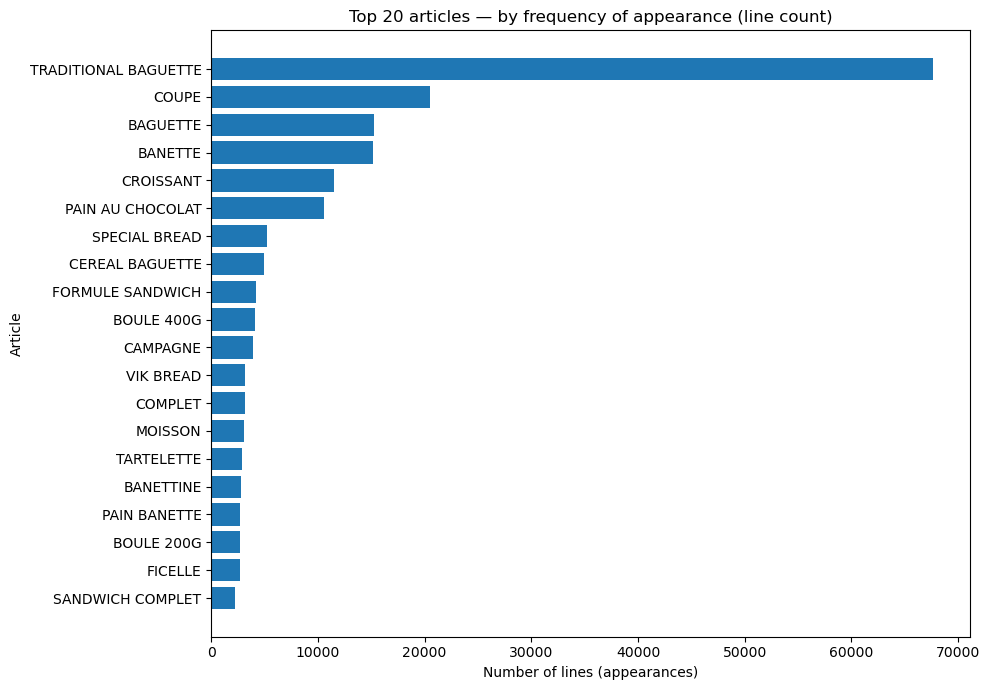

In [54]:
plot_top_n_by_linecount(popularity, n=TOP_N)

# wich article represents the greatest contribution to the chiffre d'affaire


In [75]:
sum_price_by_article = (
    df.groupby("article")["unit_price"]
      .sum()
      .sort_values(ascending=False)
      .reset_index(name="total_unit_price")
    .assign(pct=lambda x: (x['total_unit_price'] / x['total_unit_price'].sum()) * 100)
)
sum_price_by_article[:15]

,article,total_unit_price,pct
0,TRADITIONAL BAGUETTE,83400.15,21.441731
1,FORMULE SANDWICH,28179.00,7.244670
2,BANETTE,16343.20,4.201749
3,BAGUETTE,14208.00,3.652801
4,PAIN AU CHOCOLAT,13036.20,3.351537
5,CROISSANT,13030.55,3.350085
6,SPECIAL BREAD,12776.30,3.284718
7,TRAITEUR,11190.88,2.877115
8,SANDWICH COMPLET,10383.00,2.669414
9,GRAND FAR BRETON,9931.50,2.553335


In [74]:
popularity[popularity["article"]=="FORMULE SANDWICH"]

,article,total_quantity,line_count
8,FORMULE SANDWICH,5181.0,4202
